<a href="https://colab.research.google.com/github/fvillena/dcc-ia-nlp/blob/master/8-sequences-seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Summary of my results:

model            | train_loss | valid_loss | seq2seq_acc | bleu
-------------------|----------|----------|----------|----------
seq2seq            | 3.355085 | 4.272877 | 0.382089 | 0.291899
\+ teacher forcing | 3.154585 |	4.022432 | 0.407792 | 0.310715
\+ attention       | 1.452292 | 3.420485 | 0.498205 | 0.413232
transformer        | 1.913152 | 2.349686 | 0.781749 | 0.612880

# Translation with an RNN

This notebook is modified from [this one](https://github.com/fastai/fastai_docs/blob/master/dev_course/dl2/translation.ipynb) created by Sylvain Gugger.

Today we will be tackling the task of translation. We will be translating from French to English, and to keep our task a manageable size, we will limit ourselves to translating questions.

This task is an example of sequence to sequence (seq2seq). Seq2seq can be more challenging than classification, since the output is of variable length (and typically different from the length of the input.

French/English parallel texts from http://www.statmt.org/wmt15/translation-task.html .  It was created by Chris Callison-Burch, who crawled millions of web pages and then used *a set of simple heuristics to transform French URLs onto English URLs (i.e. replacing "fr" with "en" and about 40 other hand-written rules), and assume that these documents are translations of each other*.

Translation is much tougher in straight PyTorch: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

In [ ]:
from fastai.text import *

## Download and preprocess our data

We will start by reducing the original dataset to questions. You only need to execute this once, uncomment to run. The dataset can be downloaded [here](https://s3.amazonaws.com/fast-ai-nlp/giga-fren.tgz).

In [ ]:
path = Config().data_path()
print(path)

/root/.fastai/data


In [ ]:
! wget https://s3.amazonaws.com/fast-ai-nlp/giga-fren.tgz -P {path}

--2020-11-16 01:45:18--  https://s3.amazonaws.com/fast-ai-nlp/giga-fren.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.93.54
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.93.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2598183296 (2.4G) [application/x-tar]
Saving to: ‘/root/.fastai/data/giga-fren.tgz’

giga-fren.tgz       100%[===================>]   2.42G  25.2MB/s    in 90s     

2020-11-16 01:46:49 (27.5 MB/s) - ‘/root/.fastai/data/giga-fren.tgz’ saved [2598183296/2598183296]



In [ ]:
! tar xf {path}/giga-fren.tgz -C {path} 

In [ ]:
path = Config().data_path()/'giga-fren'
path.ls()

[PosixPath('/root/.fastai/data/giga-fren/giga-fren.release2.fixed.fr'),
 PosixPath('/root/.fastai/data/giga-fren/giga-fren.release2.fixed.en')]

In [ ]:
with open(path/'giga-fren.release2.fixed.fr') as f:
  fr = []
  max_lines = 1000
  for i,line in enumerate(f):
    if i < max_lines:
      fr.append(line.rstrip())
    else:
      break

In [ ]:
with open(path/'giga-fren.release2.fixed.en') as f:
  en = []
  max_lines = 1000
  for i,line in enumerate(f):
    if i < max_lines:
      en.append(line.rstrip())
    else:
      break

In [ ]:
# with open(path/'giga-fren.release2.fixed.fr') as f: fr = f.read().split('\n')

In [ ]:
# with open(path/'giga-fren.release2.fixed.en') as f: en = f.read().split('\n')

We will use regex to pick out questions by finding the strings in the English dataset that start with "Wh" and end with a question mark.  You only need to run these lines once:

In [ ]:
 re_eq = re.compile('^(Wh[^?.!]+\?)')
 re_fq = re.compile('^([^?.!]+\?)')
 en_fname = path/'giga-fren.release2.fixed.en'
 fr_fname = path/'giga-fren.release2.fixed.fr'

In [ ]:
lines = ((re_eq.search(eq), re_fq.search(fq)) 
        for eq, fq in zip(open(en_fname, encoding='utf-8'), open(fr_fname, encoding='utf-8')))
qs = [(e.group(), f.group()) for e,f in lines if e and f]

In [ ]:
qs = [(q1,q2) for q1,q2 in qs]
df = pd.DataFrame({'fr': [q[1] for q in qs], 'en': [q[0] for q in qs]}, columns = ['en', 'fr'])
df.to_csv(path/'questions_easy.csv', index=False)

In [ ]:
path.ls()

[PosixPath('/root/.fastai/data/giga-fren/giga-fren.release2.fixed.fr'),
 PosixPath('/root/.fastai/data/giga-fren/giga-fren.release2.fixed.en'),
 PosixPath('/root/.fastai/data/giga-fren/questions_easy.csv')]

## Load our data into a DataBunch

Our questions look like this now:

In [ ]:
df = pd.read_csv('/root/.fastai/data/giga-fren/questions_easy.csv')
df.head()

,en,fr
0,What is light ?,Qu’est-ce que la lumière?
1,Who are we?,Où sommes-nous?
2,Where did we come from?,D'où venons-nous?
3,What would we do without it?,Que ferions-nous sans elle ?
4,What is the absolute location (latitude and lo...,Quelle sont les coordonnées (latitude et longi...


To make it simple, we lowercase everything.

In [ ]:
df['en'] = df['en'].apply(lambda x:x.lower())
df['fr'] = df['fr'].apply(lambda x:x.lower())

The first thing is that we will need to collate inputs and targets in a batch: they have different lengths so we need to add padding to make the sequence length the same;

In [ ]:
def seq2seq_collate(samples, pad_idx=1, pad_first=True, backwards=False):
    "Function that collect samples and adds padding. Flips token order if needed"
    samples = to_data(samples)
    max_len_x,max_len_y = max([len(s[0]) for s in samples]),max([len(s[1]) for s in samples])
    res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx
    if backwards: pad_first = not pad_first
    for i,s in enumerate(samples):
        if pad_first: 
            res_x[i,-len(s[0]):],res_y[i,-len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
        else:         
            res_x[i,:len(s[0]):],res_y[i,:len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
    if backwards: res_x,res_y = res_x.flip(1),res_y.flip(1)
    return res_x,res_y

Then we create a special `DataBunch` that uses this collate function.

In [ ]:
doc(Dataset)

In [ ]:
doc(DataLoader)

In [ ]:
doc(DataBunch)

In [ ]:
class Seq2SeqDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training an RNN classifier."
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=32, val_bs:int=None, pad_idx=1,
               dl_tfms=None, pad_first=False, device:torch.device=None, no_check:bool=False, backwards:bool=False, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)

In [ ]:
SortishSampler??

And a subclass of `TextList` that will use this `DataBunch` class in the call `.databunch` and will use `TextList` to label (since our targets are other texts).

In [ ]:
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch
    _label_cls = TextList

Thats all we need to use the data block API!

In [80]:
src = Seq2SeqTextList.from_df(df, path = path, cols='fr').split_by_rand_pct(seed=42).label_from_df(cols='en', label_cls=TextList)

In [81]:
np.percentile([len(o) for o in src.train.x.items] + [len(o) for o in src.valid.x.items], 90)

28.0

In [82]:
np.percentile([len(o) for o in src.train.y.items] + [len(o) for o in src.valid.y.items], 90)

23.0

We remove the items where one of the target is more than 30 tokens long.

In [83]:
src = src.filter_by_func(lambda x,y: len(x) > 30 or len(y) > 30)

In [84]:
len(src.train) + len(src.valid)

48350

In [85]:
data = src.databunch()

In [86]:
data.save()

In [87]:
data

Seq2SeqDataBunch;

Train: LabelList (38704 items)
x: Seq2SeqTextList
xxbos qu’est - ce que la lumière ?,xxbos où sommes - nous ?,xxbos d'où venons - nous ?,xxbos que ferions - nous sans elle ?,xxbos quel est le groupe autochtone principal sur l’île de vancouver ?
y: TextList
xxbos what is light ?,xxbos who are we ?,xxbos where did we come from ?,xxbos what would we do without it ?,xxbos what is the major aboriginal group on vancouver island ?
Path: /root/.fastai/data/giga-fren;

Valid: LabelList (9646 items)
x: Seq2SeqTextList
xxbos quels pourraient être les effets sur l’instrument de xxunk et sur l’aide humanitaire qui ne sont pas co - xxunk ?,xxbos quand la source primaire a - t - elle été créée ?,xxbos pourquoi tant de soldats ont - ils fait xxunk de ne pas voir ce qui s'est passé le 4 et le 16 mars ?,xxbos quels sont les taux d'impôt sur le revenu au canada pour 2007 ?,xxbos pourquoi le programme devrait - il intéresser les employeurs et les fournisseurs de services ?
y: TextList
x

In [88]:
path

PosixPath('/root/.fastai/data/giga-fren')

In [89]:
data = load_data(path)

In [90]:
data.show_batch()

text,target
"xxbos quels services offrez - vous aux résidents , par l'entremise de votre propre organisation , par l'entremise de liens / partenariats avec des organismes communautaires ou les deux ?",xxbos which of the following services do you offer to residents either through your own organization or through linkages and / or partnerships with community agencies or both ?
"xxbos quelles initiatives ont été prises , conformément aux recommandations précédentes du comité , pour sensibiliser tant les hommes que les femmes à la contraception et aux méthodes xxunk ?","xxbos what steps have been taken , in line with the committee ’s previous recommendations , to raise awareness about contraception and xxunk methods among both men and women ?"
xxbos qu’en est - il d’un leader qui ne possède que deux de ces caractéristiques ou de celui qui ne manifeste que de temps en temps certains comportements xxunk ?,xxbos what if a leader xxunk only two of the factors ?
"xxbos quels mécanismes d'évaluation , de surveillance ou de responsabilisation sont en place pour l'étude de cas , tant dans le cadre de l'initiative qu'à l'intérieur de votre organisation ?","xxbos what evaluation , monitoring or other accountability mechanisms are in place for this work , within the initiative and within your organization ?"
"xxbos quelles sont les hypothèses , selon la définition actuelle du développement , do nt les pays en développement sont censés s'inspirer pour réformer leurs systèmes de politique sociale ?",xxbos what are the assumptions in the current understanding of development that developing countries are expected to accommodate in reforming their social - policy systems ?


## Create our Model

### Pretrained embeddings

You will need to download the word embeddings (crawl vectors) from the fastText docs. FastText has [pre-trained word vectors](https://fasttext.cc/docs/en/crawl-vectors.html) for 157 languages, trained on Common Crawl and Wikipedia. These models were trained using CBOW.

If you need a refresher on word embeddings, you can check out my gentle intro in [this word embedding workshop](https://www.youtube.com/watch?v=25nC0n9ERq4&list=PLtmWHNX-gukLQlMvtRJ19s7-8MrnRV6h6&index=10&t=0s) with accompanying [github repo](https://github.com/fastai/word-embeddings-workshop). 

More reading on CBOW (Continuous Bag of Words vs. Skip-grams):

- [fastText tutorial](https://fasttext.cc/docs/en/unsupervised-tutorial.html#advanced-readers-skipgram-versus-cbow)
- [StackOverflow](https://stackoverflow.com/questions/38287772/cbow-v-s-skip-gram-why-invert-context-and-target-words)

Para instalar fastText con pip:
```
$ git clone https://github.com/facebookresearch/fastText.git
$ cd fastText
$ pip install .
```

Para instalar fastText con anaconda:
```
$conda install -c conda-forge fasttext
```

In [91]:
# !git clone https://github.com/facebookresearch/fastText.git
# !cd fastText; pip install .

In [92]:
# import fasttext as ft

The lines to download the word vectors only need to be run once:

In [93]:
# ! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz -P {path}
# ! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.bin.gz -P {path}

In [94]:
# !gunzip {path}/cc.en.300.bin.gz
# !gunzip {path}/cc.fr.300.bin.gz

In [95]:
# fr_vecs = ft.load_model(str(('/root/.fastai/data/giga-fren/cc.fr.300.bin')))

In [96]:
# en_vecs = ft.load_model(str(('/root/.fastai/data/giga-fren/cc.en.300.bin')))

We create an embedding module with the pretrained vectors and random data for the missing parts.

In [97]:
def create_emb(vecs, itos, em_sz=300, mult=1.):
    emb = nn.Embedding(len(itos), em_sz, padding_idx=1)
    wgts = emb.weight.data
    # vec_dic = {w:vecs.get_word_vector(w) for w in vecs.get_words()}
    vec_dic = {}
    miss = []
    for i,w in enumerate(itos):
        try: wgts[i] = tensor(vec_dic[w])
        except: miss.append(w)
    return emb

In [98]:
emb_enc = create_emb(None, data.x.vocab.itos)
emb_dec = create_emb(None, data.y.vocab.itos)

In [99]:
#emb_enc.weight.size(), emb_dec.weight.size()

In [100]:
#model_path = Config().model_path()

In [101]:
#torch.save(emb_enc, model_path/'fr_emb.pth')
#torch.save(emb_dec, model_path/'en_emb.pth')

In [102]:
# emb_enc = torch.load('fr_emb.pth')
# emb_dec = torch.load('en_emb.pth')

## Our Model

### Encoders & Decoders

The model in itself consists in an encoder and a decoder


The encoder is a recurrent neural net and we feed it our input sentence, producing an output (that we discard for now) and a hidden state.  A **hidden state** is the activations that come out of an RNN.

That hidden state is then given to the decoder (an other RNN) which uses it in conjunction with the outputs it predicts to get produce the translation. We loop until the decoder produces a padding token (or at 30 iterations to make sure it's not an infinite loop at the beginning of training). 

We will use a GRU for our encoder and a separate GRU for our decoder. Other options are to use LSTMs or QRNNs (see here).  GRUs, LSTMs, and QRNNs all solve the problem of how RNNs can lack long-term memory.

Links:
- [Illustrated Guide to LSTM’s and GRU’s: A step by step explanation](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)
- [fast.ai implementation of seq2seq with QRNNs](https://github.com/fastai/fastai_docs/blob/master/dev_course/dl2/translation.ipynb)

In [103]:
class Seq2SeqRNN(nn.Module):
    def __init__(self, emb_enc, emb_dec, 
                    nh, out_sl, 
                    nl=2, bos_idx=0, pad_idx=1):
        super().__init__()
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.bos_idx,self.pad_idx = bos_idx,pad_idx
        self.em_sz_enc = emb_enc.embedding_dim
        self.em_sz_dec = emb_dec.embedding_dim
        self.voc_sz_dec = emb_dec.num_embeddings
                 
        self.emb_enc = emb_enc
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(self.em_sz_enc, nh, num_layers=nl,
                              dropout=0.25, batch_first=True)
        self.out_enc = nn.Linear(nh, self.em_sz_dec, bias=False)
        
        self.emb_dec = emb_dec
        self.gru_dec = nn.GRU(self.em_sz_dec, self.em_sz_dec, num_layers=nl,
                              dropout=0.1, batch_first=True)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(self.em_sz_dec, self.voc_sz_dec)
        self.out.weight.data = self.emb_dec.weight.data
        
    def encoder(self, bs, inp):
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        _, h = self.gru_enc(emb, h)
        h = self.out_enc(h)
        return h
    
    def decoder(self, dec_inp, h):
        emb = self.emb_dec(dec_inp).unsqueeze(1)
        outp, h = self.gru_dec(emb, h)
        outp = self.out(self.out_drop(outp[:,0]))
        return h, outp
        
    def forward(self, inp):
        bs, sl = inp.size()
        h = self.encoder(bs, inp)
        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
        
        res = []
        for i in range(self.out_sl):
            h, outp = self.decoder(dec_inp, h)
            dec_inp = outp.max(1)[1]
            res.append(outp)
            if (dec_inp==self.pad_idx).all(): break
        return torch.stack(res, dim=1)
    
    def initHidden(self, bs): return one_param(self).new_zeros(self.nl, bs, self.nh)

In [104]:
xb,yb = next(iter(data.valid_dl))

In [105]:
xb.shape

torch.Size([64, 30])

In [106]:
rnn = Seq2SeqRNN(emb_enc, emb_dec, 256, 30)

In [107]:
rnn

Seq2SeqRNN(
  (emb_enc): Embedding(11336, 300, padding_idx=1)
  (emb_enc_drop): Dropout(p=0.15, inplace=False)
  (gru_enc): GRU(300, 256, num_layers=2, batch_first=True, dropout=0.25)
  (out_enc): Linear(in_features=256, out_features=300, bias=False)
  (emb_dec): Embedding(8144, 300, padding_idx=1)
  (gru_dec): GRU(300, 300, num_layers=2, batch_first=True, dropout=0.1)
  (out_drop): Dropout(p=0.35, inplace=False)
  (out): Linear(in_features=300, out_features=8144, bias=True)
)

In [108]:
len(xb[0])

30

In [109]:
h = rnn.encoder(64, xb.cpu())

In [110]:
h.size()

torch.Size([2, 64, 300])

The loss pads output and target so that they are of the same size before using the usual flattened version of cross entropy. We do the same for accuracy.

In [111]:
def seq2seq_loss(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    return CrossEntropyFlat()(out, targ)

## Train our model

In [112]:
learn = Learner(data, rnn, loss_func=seq2seq_loss)

In [113]:
learn.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


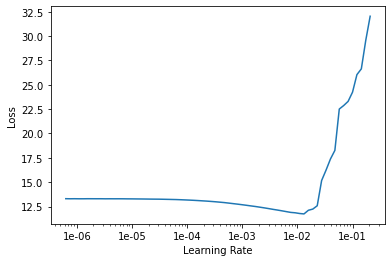

In [114]:
learn.recorder.plot()

Estos deberian mas epocs, pero demora aprox 10m por epoc

In [115]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,time
0,5.068317,5.950394,00:33


Let's free up some RAM

In [116]:
# del fr_vecs
# del en_vecs

In [117]:
def get_predictions(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    inputs, targets, outputs = [],[],[]
    with torch.no_grad():
        for xb,yb in progress_bar(learn.dl(ds_type)):
            out = learn.model(xb)
            for x,y,z in zip(xb,yb,out):
                inputs.append(learn.data.train_ds.x.reconstruct(x.cpu()))
                targets.append(learn.data.train_ds.y.reconstruct(y.cpu()))
                outputs.append(learn.data.train_ds.y.reconstruct(z.cpu().argmax(1)))
    return inputs, targets, outputs

Veremos algunos resultados

In [118]:
inputs, targets, outputs = get_predictions(learn)
inputs[325], targets[325], outputs[325]

(Text [   2   32  153  383   14  234   10 1541   16 2867  759   21   12 1943 3519   12  215 2565   37   12  215    0   26
   248   25  139    9],
 Text [   2   11   44   10  552   24   20   10 1971  238  691 1826 1466  222   25  222 2413   28   77    9],
 Text [ 2 11 15 10 10 10 10 12 10 10 10 13 10])

In [119]:
" ".join([data.x.vocab.itos[t] for t in inputs[325].data]), " ".join([data.y.vocab.itos[t] for t in targets[325].data]), " ".join([data.y.vocab.itos[t] for t in outputs[325].data])

('xxbos quel serait donc le point de départ des transferts financiers pour les médecins -- les coûts historiques ou les coûts xxunk en fonction du besoin ?',
 'xxbos what would the basis be for the physician financial transfer -- historical costs or costs projected on need ?',
 'xxbos what is the the the the of the the the to the')

As loss is not very interpretable, let's also look at the accuracy.  Again, we will add padding so that the output and target are of the same length.

In [120]:
def seq2seq_acc(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    out = out.argmax(2)
    return (out==targ).float().mean()

### Bleu metric (see dedicated notebook)

In translation, the metric usually used is BLEU.

A great post by Rachael Tatman: [Evaluating Text Output in NLP: BLEU at your own risk](https://towardsdatascience.com/evaluating-text-output-in-nlp-bleu-at-your-own-risk-e8609665a213)

In [121]:
class NGram():
    def __init__(self, ngram, max_n=5000): self.ngram,self.max_n = ngram,max_n
    def __eq__(self, other):
        if len(self.ngram) != len(other.ngram): return False
        return np.all(np.array(self.ngram) == np.array(other.ngram))
    def __hash__(self): return int(sum([o * self.max_n**i for i,o in enumerate(self.ngram)]))

In [122]:
def get_grams(x, n, max_n=5000):
    return x if n==1 else [NGram(x[i:i+n], max_n=max_n) for i in range(len(x)-n+1)]

In [123]:
def get_correct_ngrams(pred, targ, n, max_n=5000):
    pred_grams,targ_grams = get_grams(pred, n, max_n=max_n),get_grams(targ, n, max_n=max_n)
    pred_cnt,targ_cnt = Counter(pred_grams),Counter(targ_grams)
    return sum([min(c, targ_cnt[g]) for g,c in pred_cnt.items()]),len(pred_grams)

In [124]:
class CorpusBLEU(Callback):
    def __init__(self, vocab_sz):
        self.vocab_sz = vocab_sz
        self.name = 'bleu'
    
    def on_epoch_begin(self, **kwargs):
        self.pred_len,self.targ_len,self.corrects,self.counts = 0,0,[0]*4,[0]*4
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        last_output = last_output.argmax(dim=-1)
        for pred,targ in zip(last_output.cpu().numpy(),last_target.cpu().numpy()):
            self.pred_len += len(pred)
            self.targ_len += len(targ)
            for i in range(4):
                c,t = get_correct_ngrams(pred, targ, i+1, max_n=self.vocab_sz)
                self.corrects[i] += c
                self.counts[i]   += t
    
    def on_epoch_end(self, last_metrics, **kwargs):
        precs = [c/t for c,t in zip(self.corrects,self.counts)]
        len_penalty = exp(1 - self.targ_len/self.pred_len) if self.pred_len < self.targ_len else 1
        bleu = len_penalty * ((precs[0]*precs[1]*precs[2]*precs[3]) ** 0.25)
        return add_metrics(last_metrics, bleu)

### Training with metrics

In [125]:
learn = Learner(data, rnn, loss_func=seq2seq_loss, metrics=[seq2seq_acc, CorpusBLEU(len(data.y.vocab.itos))])

In [126]:
learn.lr_find()

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


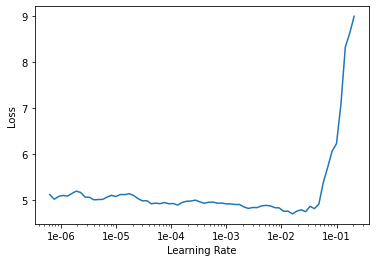

In [127]:
learn.recorder.plot()

Esto deberian ser al menos 3 epochs

In [128]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,4.961086,5.609962,0.252888,0.196936,00:40


In [129]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,4.781652,5.544357,0.259000,0.201030,00:40


So how good is our model? Let's see a few predictions.

In [130]:
inputs, targets, outputs = get_predictions(learn)

In [131]:
" ".join([data.x.vocab.itos[t] for t in inputs[700].data]), " ".join([data.y.vocab.itos[t] for t in targets[700].data]), " ".join([data.y.vocab.itos[t] for t in outputs[700].data])

("xxbos qui a le pouvoir de modifier le règlement sur les poids et mesures et le règlement sur l'inspection de l'électricité et du gaz ?",
 'xxbos who has the authority to change the electricity and gas inspection regulations and the weights and measures regulations ?',
 'xxbos who will the the the and and the and')

In [132]:
" ".join([data.x.vocab.itos[t] for t in inputs[701].data]), " ".join([data.y.vocab.itos[t] for t in targets[701].data]), " ".join([data.y.vocab.itos[t] for t in outputs[701].data])

('xxbos ´ ` ou sont xxunk leurs grandes convictions en ce qui a trait a la ` ` ´ transparence et a la responsabilite ?',
 'xxbos what happened to their great xxunk about transparency and accountability ?',
 'xxbos what are the the the the and and and and')

In [133]:
" ".join([data.x.vocab.itos[t] for t in inputs[2513].data]), " ".join([data.y.vocab.itos[t] for t in targets[2513].data]), " ".join([data.y.vocab.itos[t] for t in outputs[2513].data])

('xxbos quelles sont les deux tendances qui ont nuit à la pêche au saumon dans cette province ?',
 'xxbos what two trends negatively affected the province ’s salmon fishery ?',
 'xxbos what are the the the the the in in in in in')

In [134]:
" ".join([data.x.vocab.itos[t] for t in inputs[4000].data]), " ".join([data.y.vocab.itos[t] for t in targets[4000].data]), " ".join([data.y.vocab.itos[t] for t in outputs[4000].data])

('xxbos où les aires marines nationales de conservation du canada seront - elles situées ?',
 'xxbos where will national marine conservation areas of canada be located ?',
 'xxbos where is the the the the the')

It's usually beginning well, but falls into repeated words at the end of the question.

## Teacher forcing

One way to help training is to help the decoder by feeding it the real targets instead of its predictions (if it starts with wrong words, it's very unlikely to give us the right translation). We do that all the time at the beginning, then progressively reduce the amount of teacher forcing.

In [135]:
class TeacherForcing(LearnerCallback):
    
    def __init__(self, learn, end_epoch):
        super().__init__(learn)
        self.end_epoch = end_epoch
    
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        if train: return {'last_input': [last_input, last_target]}
    
    def on_epoch_begin(self, epoch, **kwargs):
        self.learn.model.pr_force = 1 - epoch/self.end_epoch

We will add the following code to our `forward` method:

```
    if (targ is not None) and (random.random()<self.pr_force):
        if i>=targ.shape[1]: break
        dec_inp = targ[:,i]
```
Additionally, `forward` will take an additional argument of `target`.

In [136]:
class Seq2SeqRNN_tf(nn.Module):
    def __init__(self, emb_enc, emb_dec, nh, out_sl, nl=2, bos_idx=0, pad_idx=1):
        super().__init__()
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.bos_idx,self.pad_idx = bos_idx,pad_idx
        self.em_sz_enc = emb_enc.embedding_dim
        self.em_sz_dec = emb_dec.embedding_dim
        self.voc_sz_dec = emb_dec.num_embeddings
                 
        self.emb_enc = emb_enc
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(self.em_sz_enc, nh, num_layers=nl,
                              dropout=0.25, batch_first=True)
        self.out_enc = nn.Linear(nh, self.em_sz_dec, bias=False)
        
        self.emb_dec = emb_dec
        self.gru_dec = nn.GRU(self.em_sz_dec, self.em_sz_dec, num_layers=nl,
                              dropout=0.1, batch_first=True)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(self.em_sz_dec, self.voc_sz_dec)
        self.out.weight.data = self.emb_dec.weight.data
        self.pr_force = 0.
        
    def encoder(self, bs, inp):
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        _, h = self.gru_enc(emb, h)
        h = self.out_enc(h)
        return h
    
    def decoder(self, dec_inp, h):
        emb = self.emb_dec(dec_inp).unsqueeze(1)
        outp, h = self.gru_dec(emb, h)
        outp = self.out(self.out_drop(outp[:,0]))
        return h, outp
            
    def forward(self, inp, targ=None):
        bs, sl = inp.size()
        h = self.encoder(bs, inp)
        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
        
        res = []
        for i in range(self.out_sl):
            h, outp = self.decoder(dec_inp, h)
            res.append(outp)
            dec_inp = outp.max(1)[1]
            if (dec_inp==self.pad_idx).all(): break
            if (targ is not None) and (random.random()<self.pr_force):
                if i>=targ.shape[1]: continue
                dec_inp = targ[:,i]
        return torch.stack(res, dim=1)

    def initHidden(self, bs): return one_param(self).new_zeros(self.nl, bs, self.nh)

In [137]:
rnn_tf = Seq2SeqRNN_tf(emb_enc, emb_dec, 256, 30)

learn = Learner(data, rnn_tf, loss_func=seq2seq_loss, metrics=[seq2seq_acc, CorpusBLEU(len(data.y.vocab.itos))],
               callback_fns=partial(TeacherForcing, end_epoch=3))

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


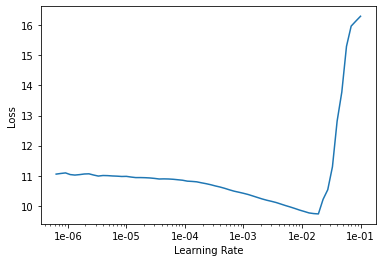

In [138]:
learn.lr_find()
learn.recorder.plot()

In [139]:
learn.fit_one_cycle(1, 3e-3)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,2.243379,5.374770,0.531169,0.351854,00:55


In [140]:
inputs, targets, outputs = get_predictions(learn)

In [141]:
" ".join([data.x.vocab.itos[t] for t in inputs[700].data]), " ".join([data.y.vocab.itos[t] for t in targets[700].data]), " ".join([data.y.vocab.itos[t] for t in outputs[700].data])

("xxbos qui a le pouvoir de modifier le règlement sur les poids et mesures et le règlement sur l'inspection de l'électricité et du gaz ?",
 'xxbos who has the authority to change the electricity and gas inspection regulations and the weights and measures regulations ?',
 'xxbos who has the impact of the xxunk on the xxunk and xxunk ?')

In [142]:
" ".join([data.x.vocab.itos[t] for t in inputs[701].data]), " ".join([data.y.vocab.itos[t] for t in targets[701].data]), " ".join([data.y.vocab.itos[t] for t in outputs[701].data])

('xxbos ´ ` ou sont xxunk leurs grandes convictions en ce qui a trait a la ` ` ´ transparence et a la responsabilite ?',
 'xxbos what happened to their great xxunk about transparency and accountability ?',
 'xxbos what are the key of the xxunk and what is the xxunk of the xxunk ?')

In [143]:
" ".join([data.x.vocab.itos[t] for t in inputs[2513].data]), " ".join([data.y.vocab.itos[t] for t in targets[2513].data]), " ".join([data.y.vocab.itos[t] for t in outputs[2513].data])

('xxbos quelles sont les deux tendances qui ont nuit à la pêche au saumon dans cette province ?',
 'xxbos what two trends negatively affected the province ’s salmon fishery ?',
 'xxbos what are the main challenges in the xxunk ?')

In [144]:
" ".join([data.x.vocab.itos[t] for t in inputs[4000].data]), " ".join([data.y.vocab.itos[t] for t in targets[4000].data]), " ".join([data.y.vocab.itos[t] for t in outputs[4000].data])

('xxbos où les aires marines nationales de conservation du canada seront - elles situées ?',
 'xxbos where will national marine conservation areas of canada be located ?',
 "xxbos where will the government of canada 's xxunk ?")

# Seq2Seq Translation with Attention

Attention is a technique that uses the output of our encoder: instead of discarding it entirely, we use it with our hidden state to pay attention to specific words in the input sentence for the predictions in the output sentence. Specifically, we compute attention weights, then add to the input of the decoder the linear combination of the output of the encoder, with those attention weights.

A second things that might help is to use a bidirectional model for the encoder. We set the `bidrectional` parameter to `True` for our GRU encoder, and double the number of inputs to the linear output layer of the encoder.

Also, we now need to set our hidden state:

```
hid = hid.view(2,self.n_layers, bs, self.n_hid).permute(1,2,0,3).contiguous()
hid = self.out_enc(self.hid_dp(hid).view(self.n_layers, bs, 2*self.n_hid))
```

In [ ]:
data = load_data(path)

In [ ]:
class TeacherForcing(LearnerCallback):
    def __init__(self, learn, end_epoch):
        super().__init__(learn)
        self.end_epoch = end_epoch
    
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        if train: return {'last_input': [last_input, last_target]}
    
    def on_epoch_begin(self, epoch, **kwargs):
        self.learn.model.pr_force = 1 - epoch/self.end_epoch

### Implementing attention

In [ ]:
class Seq2SeqRNN_attn(nn.Module):
    def __init__(self, emb_enc, emb_dec, nh, out_sl, nl=2, bos_idx=0, pad_idx=1):
        super().__init__()
        self.nl,self.nh,self.out_sl,self.pr_force = nl,nh,out_sl,1
        self.bos_idx,self.pad_idx = bos_idx,pad_idx
        self.emb_enc,self.emb_dec = emb_enc,emb_dec
        self.emb_sz_enc,self.emb_sz_dec = emb_enc.embedding_dim,emb_dec.embedding_dim
        self.voc_sz_dec = emb_dec.num_embeddings
                 
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(self.emb_sz_enc, nh, num_layers=nl, dropout=0.25, 
                              batch_first=True, bidirectional=True)
        self.out_enc = nn.Linear(2*nh, self.emb_sz_dec, bias=False)
        
        self.gru_dec = nn.GRU(self.emb_sz_dec + 2*nh, self.emb_sz_dec, num_layers=nl,
                              dropout=0.1, batch_first=True)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(self.emb_sz_dec, self.voc_sz_dec)
        self.out.weight.data = self.emb_dec.weight.data
        
        self.enc_att = nn.Linear(2*nh, self.emb_sz_dec, bias=False)
        self.hid_att = nn.Linear(self.emb_sz_dec, self.emb_sz_dec)
        self.V =  self.init_param(self.emb_sz_dec)
        
    def encoder(self, bs, inp):
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, hid = self.gru_enc(emb, 2*h)
        
        pre_hid = hid.view(2, self.nl, bs, self.nh).permute(1,2,0,3).contiguous()
        pre_hid = pre_hid.view(self.nl, bs, 2*self.nh)
        hid = self.out_enc(pre_hid)
        return hid,enc_out
    
    def decoder(self, dec_inp, hid, enc_att, enc_out):
        hid_att = self.hid_att(hid[-1])
        # we have put enc_out and hid through linear layers
        u = torch.tanh(enc_att + hid_att[:,None])
        # we want to learn the importance of each time step
        attn_wgts = F.softmax(u @ self.V, 1)
        # weighted average of enc_out (which is the output at every time step)
        ctx = (attn_wgts[...,None] * enc_out).sum(1)
        emb = self.emb_dec(dec_inp)
        # concatenate decoder embedding with context (we could have just
        # used the hidden state that came out of the decoder, if we weren't
        # using attention)
        outp, hid = self.gru_dec(torch.cat([emb, ctx], 1)[:,None], hid)
        outp = self.out(self.out_drop(outp[:,0]))
        return hid, outp
        
    def show(self, nm,v):
        if False: print(f"{nm}={v[nm].shape}")
        
    def forward(self, inp, targ=None):
        bs, sl = inp.size()
        hid,enc_out = self.encoder(bs, inp)
#        self.show("hid",vars())
        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
        enc_att = self.enc_att(enc_out)
        
        res = []
        for i in range(self.out_sl):
            hid, outp = self.decoder(dec_inp, hid, enc_att, enc_out)
            res.append(outp)
            dec_inp = outp.max(1)[1]
            if (dec_inp==self.pad_idx).all(): break
            if (targ is not None) and (random.random()<self.pr_force):
                if i>=targ.shape[1]: continue
                dec_inp = targ[:,i]
        return torch.stack(res, dim=1)

    def initHidden(self, bs): return one_param(self).new_zeros(2*self.nl, bs, self.nh)
    def init_param(self, *sz): return nn.Parameter(torch.randn(sz)/math.sqrt(sz[0]))

In [ ]:
model = Seq2SeqRNN_attn(emb_enc, emb_dec, 256, 30)
learn = Learner(data, model, loss_func=seq2seq_loss, metrics=[seq2seq_acc, CorpusBLEU(len(data.y.vocab.itos))],
                callback_fns=partial(TeacherForcing, end_epoch=30))

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


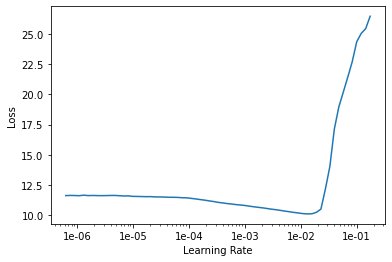

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(15, 3e-3)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,3.423893,4.188818,0.515816,0.310363,01:23
1,2.415588,3.496872,0.535154,0.288185,01:15
2,2.242313,4.460649,0.484824,0.392696,01:08
3,2.132109,4.476412,0.454946,0.382076,01:08
4,2.162826,4.416175,0.438140,0.374457,01:07
5,1.901208,4.280097,0.451268,0.382984,01:08
6,1.970231,4.056937,0.457598,0.390770,01:08
7,1.861341,3.655210,0.483136,0.404224,01:07
8,1.711661,3.855401,0.478963,0.405691,01:09
9,1.764128,4.063883,0.440086,0.388213,01:06


In [ ]:
def get_predictions(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    inputs, targets, outputs = [],[],[]
    with torch.no_grad():
        for xb,yb in progress_bar(learn.dl(ds_type)):
            out = learn.model(xb)
            for x,y,z in zip(xb,yb,out):
                inputs.append(learn.data.train_ds.x.reconstruct(x.cpu()))
                targets.append(learn.data.train_ds.y.reconstruct(y.cpu()))
                outputs.append(learn.data.train_ds.y.reconstruct(z.cpu().argmax(1)))
    return inputs, targets, outputs

In [ ]:
inputs, targets, outputs = get_predictions(learn)

In [ ]:
" ".join([data.x.vocab.itos[t] for t in inputs[700].data]), " ".join([data.y.vocab.itos[t] for t in targets[700].data]), " ".join([data.y.vocab.itos[t] for t in outputs[700].data])

("xxbos qui a le pouvoir de modifier le règlement sur les poids et mesures et le règlement sur l'inspection de l'électricité et du gaz ?",
 'xxbos who has the authority to change the electricity and gas inspection regulations and the weights and measures regulations ?',
 'xxbos who has the the the the regulations and regulations and and and and and ?')

In [ ]:
" ".join([data.x.vocab.itos[t] for t in inputs[701].data]), " ".join([data.y.vocab.itos[t] for t in targets[701].data]), " ".join([data.y.vocab.itos[t] for t in outputs[701].data])

('xxbos ´ ` ou sont xxunk leurs grandes convictions en ce qui a trait a la ` ` ´ transparence et a la responsabilite ?',
 'xxbos what happened to their great xxunk about transparency and accountability ?',
 'xxbos what are the main reasons for this ?')

In [ ]:
" ".join([data.x.vocab.itos[t] for t in inputs[2513].data]), " ".join([data.y.vocab.itos[t] for t in targets[2513].data]), " ".join([data.y.vocab.itos[t] for t in outputs[2513].data])

('xxbos quelles sont les deux tendances qui ont nuit à la pêche au saumon dans cette province ?',
 'xxbos what two trends negatively affected the province ’s salmon fishery ?',
 'xxbos what are the two trends in the xxunk in the province ?')

In [ ]:
" ".join([data.x.vocab.itos[t] for t in inputs[4000].data]), " ".join([data.y.vocab.itos[t] for t in targets[4000].data]), " ".join([data.y.vocab.itos[t] for t in outputs[4000].data])

('xxbos où les aires marines nationales de conservation du canada seront - elles situées ?',
 'xxbos where will national marine conservation areas of canada be located ?',
 'xxbos where are national marine conservation areas in canada ?')

# Attention and the Transformer

Nvidia AI researcher [Chip Huyen](https://huyenchip.com/) wrote a great post [Top 8 trends from ICLR 2019](https://huyenchip.com/2019/05/12/top-8-trends-from-iclr-2019.html) in which one of the trends is that *RNN is losing its luster with researchers*.

There's good reason for this, RNNs can be a pain: parallelization can be tricky and they can be difficult to debug. Since language is recursive, it seemed like RNNs were a good conceptual fit with NLP, but recently methods using *attention* have been achieving state of the art results on NLP.

This is still an area of very active research, for instance, a recent paper [Pay Less Attention with Lightweight and Dynamic Convolutions](https://arxiv.org/abs/1901.10430) showed that convolutions can beat attention on some tasks, including English to German translation.  More research is needed on the various strenghts of RNNs, CNNs, and transformers/attention, and perhaps on approaches to combine the best of each.

## Transformer model

In [ ]:
def seq2seq_collate(samples, pad_idx=1, pad_first=True, backwards=False):
    "Function that collect samples and adds padding. Flips token order if needed"
    samples = to_data(samples)
    max_len_x,max_len_y = max([len(s[0]) for s in samples]),max([len(s[1]) for s in samples])
    res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx
    if backwards: pad_first = not pad_first
    for i,s in enumerate(samples):
        if pad_first: 
            res_x[i,-len(s[0]):],res_y[i,-len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
        else:         
            res_x[i, :len(s[0])],res_y[i, :len(s[1])] = LongTensor(s[0]),LongTensor(s[1])
    if backwards: res_x,res_y = res_x.flip(1),res_y.flip(1)
    return res_x, res_y

In [ ]:
class Seq2SeqDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training an RNN classifier."
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path='.', bs=32, val_bs=None, pad_idx=1,
               dl_tfms=None, pad_first=False, device=None, no_check=False, backwards=False, **dl_kwargs):
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)

In [ ]:
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch
    _label_cls = TextList

### Shifting

We add a transform to the dataloader that shifts the targets right and adds a padding at the beginning.

In [ ]:
v = data.vocab

In [ ]:
v.stoi['xxpad']

1

In [ ]:
def shift_tfm(b):
    x,y = b
    y = F.pad(y, (1, 0), value=1)
    return [x,y[:,:-1]], y[:,1:]

In [ ]:
data.add_tfm(shift_tfm)

### Embeddings

The input and output embeddings are traditional PyTorch embeddings (and we can use pretrained vectors if we want to). The transformer model isn't a recurrent one, so it has no idea of the relative positions of the words. To help it with that, they had to the input embeddings a positional encoding which is cosine of a certain frequency:

In [ ]:
d = 30
torch.arange(0., d, 2.)/d

tensor([0.0000, 0.0667, 0.1333, 0.2000, 0.2667, 0.3333, 0.4000, 0.4667, 0.5333,
        0.6000, 0.6667, 0.7333, 0.8000, 0.8667, 0.9333])

In [ ]:
class PositionalEncoding(nn.Module):
    "Encode the position with a sinusoid."
    def __init__(self, d):
        super().__init__()
        self.register_buffer('freq', 1 / (10000 ** (torch.arange(0., d, 2.)/d)))
    
    def forward(self, pos):
        inp = torch.ger(pos, self.freq)
        enc = torch.cat([inp.sin(), inp.cos()], dim=-1)
        return enc

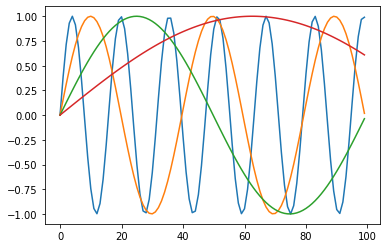

In [ ]:
tst_encoding = PositionalEncoding(20)
res = tst_encoding(torch.arange(0,100).float())
_, ax = plt.subplots(1,1)
for i in range(1,5): ax.plot(res[:,i])

In [ ]:
res[:6,:6]

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.8415,  0.3877,  0.1578,  0.0631,  0.0251,  0.0100],
        [ 0.9093,  0.7147,  0.3117,  0.1259,  0.0502,  0.0200],
        [ 0.1411,  0.9300,  0.4578,  0.1882,  0.0753,  0.0300],
        [-0.7568,  0.9998,  0.5923,  0.2497,  0.1003,  0.0400],
        [-0.9589,  0.9132,  0.7121,  0.3103,  0.1253,  0.0500]])

In [ ]:
class TransformerEmbedding(nn.Module):
    "Embedding + positional encoding + dropout"
    def __init__(self, vocab_sz, emb_sz, inp_p=0.):
        super().__init__()
        self.emb_sz = emb_sz
        self.embed = embedding(vocab_sz, emb_sz)
        self.pos_enc = PositionalEncoding(emb_sz)
        self.drop = nn.Dropout(inp_p)
    
    def forward(self, inp): 
        pos = torch.arange(0, inp.size(1), device=inp.device).float()
        return self.drop(self.embed(inp) * math.sqrt(self.emb_sz) + self.pos_enc(pos))

### Feed forward


The feed forward cell is easy: it's just two linear layers with a skip connection and a LayerNorm.

In [ ]:
def feed_forward(d_model, d_ff, ff_p=0., double_drop=True):
    layers = [nn.Linear(d_model, d_ff), nn.ReLU()]
    if double_drop: layers.append(nn.Dropout(ff_p))
    return SequentialEx(*layers, nn.Linear(d_ff, d_model), nn.Dropout(ff_p), MergeLayer(), nn.LayerNorm(d_model))

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, d_model, d_head=None, p=0., bias=True, scale=True):
        super().__init__()
        d_head = ifnone(d_head, d_model//n_heads)
        self.n_heads,self.d_head,self.scale = n_heads,d_head,scale
        self.q_wgt,self.k_wgt,self.v_wgt = [nn.Linear(
            d_model, n_heads * d_head, bias=bias) for o in range(3)]
        self.out = nn.Linear(n_heads * d_head, d_model, bias=bias)
        self.drop_att,self.drop_res = nn.Dropout(p),nn.Dropout(p)
        self.ln = nn.LayerNorm(d_model)
        
    def forward(self, q, kv, mask=None):
        return self.ln(q + self.drop_res(self.out(self._apply_attention(q, kv, mask=mask))))
    
    def create_attn_mat(self, x, layer, bs):
        return layer(x).view(bs, x.size(1), self.n_heads, self.d_head
                            ).permute(0, 2, 1, 3)
    
    def _apply_attention(self, q, kv, mask=None):
        bs,seq_len = q.size(0),q.size(1)
        wq,wk,wv = map(lambda o: self.create_attn_mat(*o,bs),
                       zip((q,kv,kv),(self.q_wgt,self.k_wgt,self.v_wgt)))
        attn_score = wq @ wk.transpose(2,3)
        if self.scale: attn_score /= math.sqrt(self.d_head)
        if mask is not None: 
            attn_score = attn_score.float().masked_fill(mask, -float('inf')).type_as(attn_score)
        attn_prob = self.drop_att(F.softmax(attn_score, dim=-1))
        attn_vec = attn_prob @ wv
        return attn_vec.permute(0, 2, 1, 3).contiguous().view(bs, seq_len, -1)

### Masking

The attention layer uses a mask to avoid paying attention to certain timesteps. The first thing is that we don't really want the network to pay attention to the padding, so we're going to mask it. The second thing is that since this model isn't recurrent, we need to mask (in the output) all the tokens we're not supposed to see yet (otherwise it would be cheating).

In [ ]:
def get_output_mask(inp, pad_idx=1):
    return torch.triu(inp.new_ones(inp.size(1),inp.size(1)), diagonal=1)[None,None].byte()
#     return ((inp == pad_idx)[:,None,:,None].long() + torch.triu(inp.new_ones(inp.size(1),inp.size(1)), diagonal=1)[None,None] != 0)

Example of mask for the future tokens:

In [ ]:
torch.triu(torch.ones(10,10), diagonal=1).byte()

tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.uint8)

### Encoder and decoder blocks


In [ ]:
class EncoderBlock(nn.Module):
    "Encoder block of a Transformer model."
    #Can't use Sequential directly cause more than one input...
    def __init__(self, n_heads, d_model, d_head, d_inner, p=0., bias=True, scale=True, double_drop=True):
        super().__init__()
        self.mha = MultiHeadAttention(n_heads, d_model, d_head, p=p, bias=bias, scale=scale)
        self.ff  = feed_forward(d_model, d_inner, ff_p=p, double_drop=double_drop)
    
    def forward(self, x, mask=None): return self.ff(self.mha(x, x, mask=mask))

In [ ]:
class DecoderBlock(nn.Module):
    "Decoder block of a Transformer model."
    #Can't use Sequential directly cause more than one input...
    def __init__(self, n_heads, d_model, d_head, d_inner, p=0., bias=True, scale=True, double_drop=True):
        super().__init__()
        self.mha1 = MultiHeadAttention(n_heads, d_model, d_head, p=p, bias=bias, scale=scale)
        self.mha2 = MultiHeadAttention(n_heads, d_model, d_head, p=p, bias=bias, scale=scale)
        self.ff   = feed_forward(d_model, d_inner, ff_p=p, double_drop=double_drop)
    
    def forward(self, x, enc, mask_out=None): return self.ff(self.mha2(self.mha1(x, x, mask_out), enc))

### The whole model

In [ ]:
class Transformer(Module):
    def __init__(self, inp_vsz, out_vsz, n_layers=6, n_heads=8, d_model=256, d_head=32, 
                 d_inner=1024, p=0.1, bias=True, scale=True, double_drop=True, pad_idx=1):
        self.enc_emb = TransformerEmbedding(inp_vsz, d_model, p)
        self.dec_emb = TransformerEmbedding(out_vsz, d_model, 0.)
        args = (n_heads, d_model, d_head, d_inner, p, bias, scale, double_drop)
        self.encoder = nn.ModuleList([EncoderBlock(*args) for _ in range(n_layers)])
        self.decoder = nn.ModuleList([DecoderBlock(*args) for _ in range(n_layers)])
        self.out = nn.Linear(d_model, out_vsz)
        self.out.weight = self.dec_emb.embed.weight
        self.pad_idx = pad_idx
        
    def forward(self, inp, out):
        mask_out = get_output_mask(out, self.pad_idx)
        enc,out = self.enc_emb(inp),self.dec_emb(out)
        enc = compose(self.encoder)(enc)
        out = compose(self.decoder)(out, enc, mask_out)
        return self.out(out)

### Training


In [ ]:
n_x_vocab,n_y_vocab = len(data.train_ds.x.vocab.itos), len(data.train_ds.y.vocab.itos)

model = Transformer(n_x_vocab, n_y_vocab, d_model=256)
learn = Learner(data, model, metrics=[accuracy, CorpusBLEU(n_y_vocab)], loss_func = CrossEntropyFlat())

epoch,train_loss,valid_loss,accuracy,bleu,time


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:28.)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


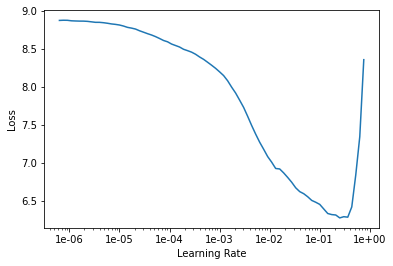

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(8, 5e-4, div_factor=5)

epoch,train_loss,valid_loss,accuracy,bleu,time
0,2.512983,2.706139,0.588503,0.438999,01:18
1,1.985475,2.169181,0.662392,0.482746,01:18
2,1.715842,1.795367,0.704635,0.520793,01:19
3,1.480635,1.599893,0.729838,0.543845,01:19
4,1.176324,1.451871,0.747660,0.566204,01:19
5,1.046271,1.401666,0.756389,0.576673,01:19
6,0.885345,1.386289,0.763615,0.587007,01:20
7,0.831202,1.385315,0.764096,0.587995,01:20


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:28.)


In [ ]:
def get_predictions(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    inputs, targets, outputs = [],[],[]
    with torch.no_grad():
        for xb,yb in progress_bar(learn.dl(ds_type)):
            out = learn.model(*xb)
            for x,y,z in zip(xb[0],xb[1],out):
                inputs.append(learn.data.train_ds.x.reconstruct(x.cpu()))
                targets.append(learn.data.train_ds.y.reconstruct(y.cpu()))
                outputs.append(learn.data.train_ds.y.reconstruct(z.cpu().argmax(1)))
    return inputs, targets, outputs

In [ ]:
inputs, targets, outputs = get_predictions(learn)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:28.)


In [ ]:
" ".join([data.x.vocab.itos[t] for t in inputs[700].data]), " ".join([data.y.vocab.itos[t] for t in targets[700].data]), " ".join([data.y.vocab.itos[t] for t in outputs[700].data])

("xxbos qui a le pouvoir de modifier le règlement sur les poids et mesures et le règlement sur l'inspection de l'électricité et du gaz ?",
 'xxbos who has the authority to change the electricity and gas inspection regulations and the weights and measures regulations ?',
 'xxbos who has the authority to change the xxunk and measures measures regulations and the cap of gas of ?')

In [ ]:
" ".join([data.x.vocab.itos[t] for t in inputs[701].data]), " ".join([data.y.vocab.itos[t] for t in targets[701].data]), " ".join([data.y.vocab.itos[t] for t in outputs[701].data])

('xxbos ´ ` ou sont xxunk leurs grandes convictions en ce qui a trait a la ` ` ´ transparence et a la responsabilite ?',
 'xxbos what happened to their great xxunk about transparency and accountability ?',
 'xxbos what are to their main cultures that transparency and responsibilities ?')

In [ ]:
" ".join([data.x.vocab.itos[t] for t in inputs[2513].data]), " ".join([data.y.vocab.itos[t] for t in targets[2513].data]), " ".join([data.y.vocab.itos[t] for t in outputs[2513].data])

('xxbos quelles sont les deux tendances qui ont nuit à la pêche au saumon dans cette province ?',
 'xxbos what two trends negatively affected the province ’s salmon fishery ?',
 'xxbos what two trends have have the growth in growth in in')

In [ ]:
" ".join([data.x.vocab.itos[t] for t in inputs[4000].data]), " ".join([data.y.vocab.itos[t] for t in targets[4000].data]), " ".join([data.y.vocab.itos[t] for t in outputs[4000].data])

('xxbos où les aires marines nationales de conservation du canada seront - elles situées ?',
 'xxbos where will national marine conservation areas of canada be located ?',
 'xxbos where will national conservation conservation areas be canada be located ?')

### Label smoothing


They point out in the paper that using label smoothing helped getting a better BLEU/accuracy, even if it made the loss worse.

In [ ]:
model = Transformer(len(data.train_ds.x.vocab.itos), len(data.train_ds.y.vocab.itos), d_model=256)

In [ ]:
learn = Learner(data, model, metrics=[accuracy, CorpusBLEU(len(data.train_ds.y.vocab.itos))], 
                loss_func=FlattenedLoss(LabelSmoothingCrossEntropy, axis=-1))

In [ ]:
learn.fit_one_cycle(8, 5e-4, div_factor=5)

epoch,train_loss,valid_loss,accuracy,bleu,time
0,3.420012,3.569326,0.588256,0.441019,01:20
1,2.997701,3.112791,0.662269,0.481235,01:20
2,2.724952,2.813745,0.703309,0.518670,01:20
3,2.478799,2.622936,0.731114,0.545982,01:20
4,2.342516,2.517119,0.747324,0.564206,01:21
5,2.130486,2.473323,0.757782,0.578507,01:22
6,2.033315,2.456378,0.762409,0.584401,01:22
7,1.960991,2.457842,0.763156,0.585655,01:22


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:28.)


In [ ]:
inputs, targets, outputs = get_predictions(learn)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:28.)


In [ ]:
" ".join([data.x.vocab.itos[t] for t in inputs[700].data]), " ".join([data.y.vocab.itos[t] for t in targets[700].data]), " ".join([data.y.vocab.itos[t] for t in outputs[700].data])

("xxbos qui a le pouvoir de modifier le règlement sur les poids et mesures et le règlement sur l'inspection de l'électricité et du gaz ?",
 'xxbos who has the authority to change the electricity and gas inspection regulations and the weights and measures regulations ?',
 'xxbos who has the power to change the weight and the regulations regulations and the advertising of gas of ?')

In [ ]:
" ".join([data.x.vocab.itos[t] for t in inputs[701].data]), " ".join([data.y.vocab.itos[t] for t in targets[701].data]), " ".join([data.y.vocab.itos[t] for t in outputs[701].data])

('xxbos ´ ` ou sont xxunk leurs grandes convictions en ce qui a trait a la ` ` ´ transparence et a la responsabilite ?',
 'xxbos what happened to their great xxunk about transparency and accountability ?',
 'xxbos what are to the main assumptions assumptions the and transparency ?')

In [ ]:
" ".join([data.x.vocab.itos[t] for t in inputs[2513].data]), " ".join([data.y.vocab.itos[t] for t in targets[2513].data]), " ".join([data.y.vocab.itos[t] for t in outputs[2513].data])

('xxbos quelles sont les deux tendances qui ont nuit à la pêche au saumon dans cette province ?',
 'xxbos what two trends negatively affected the province ’s salmon fishery ?',
 'xxbos what are trends have have the fishing in fishing in in')

In [ ]:
" ".join([data.x.vocab.itos[t] for t in inputs[4000].data]), " ".join([data.y.vocab.itos[t] for t in targets[4000].data]), " ".join([data.y.vocab.itos[t] for t in outputs[4000].data])

('xxbos où les aires marines nationales de conservation du canada seront - elles situées ?',
 'xxbos where will national marine conservation areas of canada be located ?',
 'xxbos where will national marine conservation areas be canada be located ?')

### Test leakage

If we change a token in the targets at position n, it shouldn't impact the predictions before that.

In [ ]:
learn.model.eval();

In [ ]:
xb,yb = data.one_batch(cpu=False)

In [ ]:
inp1,out1 = xb[0][:1],xb[1][:1]
inp2,out2 = inp1.clone(),out1.clone()
out2[0,15] = 10

In [ ]:
y1 = learn.model(inp1, out1)
y2 = learn.model(inp2, out2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:28.)


In [ ]:
(y1[0,:15] - y2[0,:15]).abs().mean()

tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)